In [1]:
from phoenix import distributionfunction, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/home/annalena/phoenix/phoenix/distributionfunctions_disky_Binney.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/home/annalena/phoenix/phoenix/distributionfunctions_disky_Binney.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker:

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "Rinit": 8.0, # for sampling
    "R0_thin": 5.0,
    "Rd_thin": 2.5,
    "Sigma0_thin": 100.0,
    "RsigR_thin": 18.0,
    "RsigZ_thin": 2.0,
    "sigmaR0_R0_thin": 140.0,
    "sigmaz0_R0_thin": 5.0,
    "L0_thin": 50.0,
    "Rinit_for_Rc_thin": 8.0,
}

envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)

Phi_spheroid = miyamoto_nagai_potential
theta_spheroid = jnp.array([1e12, 60.0, 0.01]) # (M, a, b) z.B. für Miyamoto-Nagai

In [3]:
#Generate candidate actions
from phoenix.distributionfunctions_disky_Binney import f_thin_disc_from_params
candidates, samples, soft_weights = sampling.sample_df_potential_single(f_thin_disc_from_params, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]


Number of candidate actions: 250000


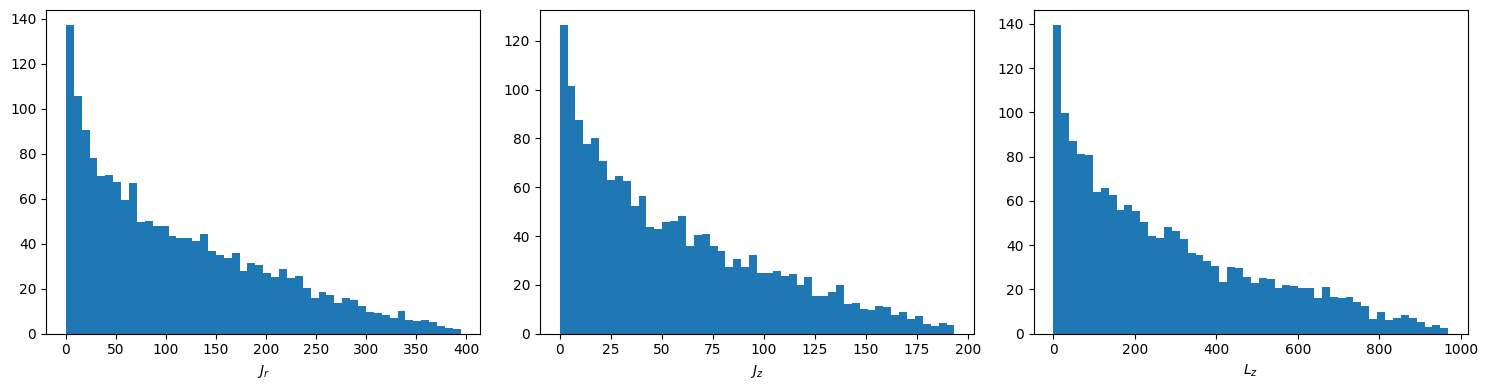

In [4]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

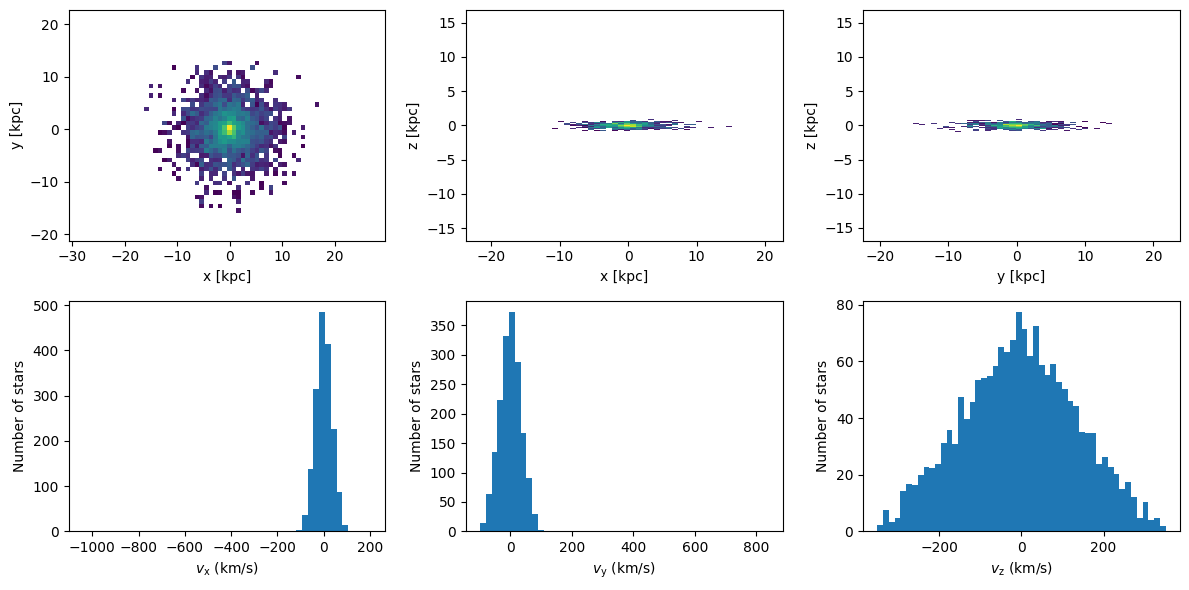

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.hist2d(x, y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(232)
plt.hist2d(x, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(233)
plt.hist2d(y, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')

plt.subplot(234)
plt.hist(v_x, bins=50, weights=soft_weights)#, range=(-2000, 2000))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(235)
plt.hist(v_y, bins=50, weights=soft_weights)#, range=(-2000, 2000))
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(236)
plt.hist(v_z, bins=50, weights=soft_weights)
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

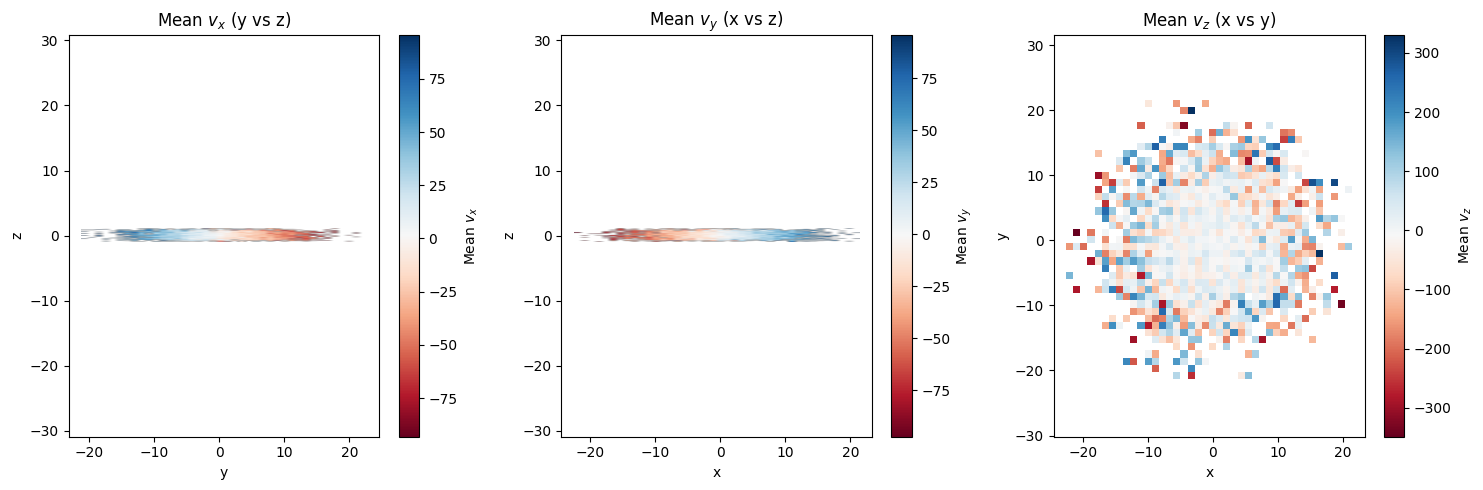

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_bins_x = 40
num_bins_y = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x.min(), x.max(), num_bins_x + 1)
y_bins = np.linspace(y.min(), y.max(), num_bins_x + 1)
z_bins = np.linspace(z.min(), z.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x, x_bins) - 1
y_idx = np.digitize(y, y_bins) - 1
z_idx = np.digitize(z, z_bins) - 1

# Initialize array for mean v_y
mean_vx = np.full((num_bins_y, num_bins_z), np.nan)
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)
mean_vz = np.full((num_bins_x, num_bins_y), np.nan)

# Calculate mean v_x for each bin
for i in range(num_bins_y):
    for j in range(num_bins_z):
        mask = (y_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vx[i, j] = np.average(v_x[mask], weights=soft_weights[mask])

# Calculate mean v_y for each bin
for i in range(num_bins_x):
    for j in range(num_bins_z):
        mask = (x_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vy[i, j] = np.average(v_y[mask], weights=soft_weights[mask])

# Calculate mean v_z for each bin
for i in range(num_bins_x):
    for j in range(num_bins_y):
        mask = (x_idx == i) & (y_idx == j)
        if np.any(mask):
            mean_vz[i, j] = np.average(v_z[mask], weights=soft_weights[mask])

# Plot mean velocity maps side-by-side (y vs z, x vs z, x vs y)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# mean_vx: y vs z
im0 = axs[0].imshow(mean_vx.T, origin='lower', aspect='auto',
                   extent=[y_bins[0], y_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[0].set_xlabel('y')
axs[0].set_ylabel('z')
axs[0].set_title('Mean $v_x$ (y vs z)')
axs[0].axis('equal')
plt.colorbar(im0, ax=axs[0], label='Mean $v_x$')

# mean_vy: x vs z
im1 = axs[1].imshow(mean_vy.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].set_title('Mean $v_y$ (x vs z)')
axs[1].axis('equal')
plt.colorbar(im1, ax=axs[1], label='Mean $v_y$')

# mean_vz: x vs y
im2 = axs[2].imshow(mean_vz.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                   cmap='RdBu')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Mean $v_z$ (x vs y)')
plt.colorbar(im2, ax=axs[2], label='Mean $v_z$')
axs[2].axis('equal')
plt.tight_layout()
plt.show()

In [7]:
params = {
    "R0": 8.0, # for actions to phase space
    "N0_spheroid": 1e6,
    "J0_spheroid": 50.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)
# Js are max 400, 400, 2000

Phi_spheroid = plummer_potential
theta_spheroid = jnp.array([1e12, 30.0]) # (M, a) z.B. für Plummer

In [8]:
#Generate candidate actions
from phoenix.distributionfunctions_spheroidal import f_double_power_law as df_spheroid
candidates, samples, soft_weights2 = sampling.sample_df_potential_single(df_spheroid, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)
x2 = phase_space_coords[:, 0]
y2 = phase_space_coords[:, 1]
z2 = phase_space_coords[:, 2]
v_x2 = phase_space_coords[:, 3]
v_y2 = phase_space_coords[:, 4]
v_z2 = phase_space_coords[:, 5]

Number of candidate actions: 250000


In [9]:
x_tot = jnp.concatenate([x, x2])
y_tot = jnp.concatenate([y, y2])
z_tot = jnp.concatenate([z, z2])
v_x_tot = jnp.concatenate([v_x, v_x2])
v_y_tot = jnp.concatenate([v_y, v_y2])
v_z_tot = jnp.concatenate([v_z, v_z2])  
soft_weights_tot = jnp.concatenate([soft_weights, soft_weights2])

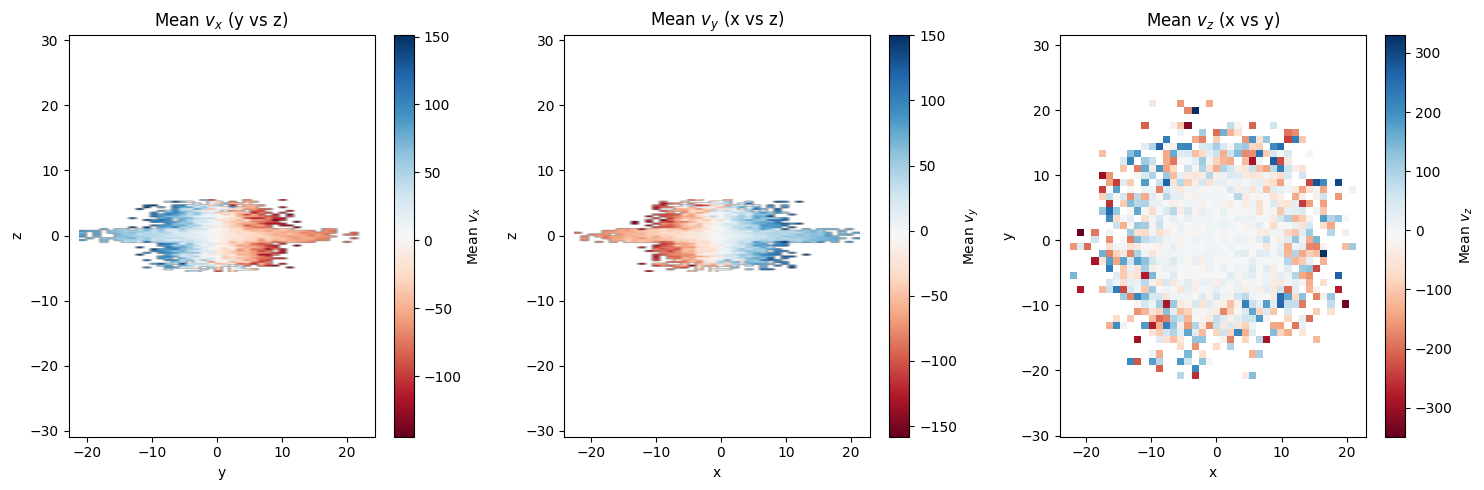

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_bins_x = 40
num_bins_y = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x_tot.min(), x_tot.max(), num_bins_x + 1)
y_bins = np.linspace(y_tot.min(), y_tot.max(), num_bins_x + 1)
z_bins = np.linspace(z_tot.min(), z_tot.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x_tot, x_bins) - 1
y_idx = np.digitize(y_tot, y_bins) - 1
z_idx = np.digitize(z_tot, z_bins) - 1

# Initialize array for mean v_y
mean_vx = np.full((num_bins_y, num_bins_z), np.nan)
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)
mean_vz = np.full((num_bins_x, num_bins_y), np.nan)

# Calculate mean v_x for each bin
for i in range(num_bins_y):
    for j in range(num_bins_z):
        mask = (y_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vx[i, j] = np.average(v_x_tot[mask], weights=soft_weights_tot[mask])

# Calculate mean v_y for each bin
for i in range(num_bins_x):
    for j in range(num_bins_z):
        mask = (x_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vy[i, j] = np.average(v_y_tot[mask], weights=soft_weights_tot[mask])

# Calculate mean v_z for each bin
for i in range(num_bins_x):
    for j in range(num_bins_y):
        mask = (x_idx == i) & (y_idx == j)
        if np.any(mask):
            mean_vz[i, j] = np.average(v_z_tot[mask], weights=soft_weights_tot[mask])

# Plot mean velocity maps side-by-side (y vs z, x vs z, x vs y)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# mean_vx: y vs z
im0 = axs[0].imshow(mean_vx.T, origin='lower', aspect='auto',
                   extent=[y_bins[0], y_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[0].set_xlabel('y')
axs[0].set_ylabel('z')
axs[0].set_title('Mean $v_x$ (y vs z)')
axs[0].axis('equal')
plt.colorbar(im0, ax=axs[0], label='Mean $v_x$')

# mean_vy: x vs z
im1 = axs[1].imshow(mean_vy.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
                   cmap='RdBu')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].set_title('Mean $v_y$ (x vs z)')
axs[1].axis('equal')
plt.colorbar(im1, ax=axs[1], label='Mean $v_y$')

# mean_vz: x vs y
im2 = axs[2].imshow(mean_vz.T, origin='lower', aspect='auto',
                   extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                   cmap='RdBu')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Mean $v_z$ (x vs y)')
plt.colorbar(im2, ax=axs[2], label='Mean $v_z$')
axs[2].axis('equal')
plt.tight_layout()
plt.show()